# Python Assignment

### Packages

In [1]:
import sys

import pandas as pd
import numpy as np
import sklearn as sk
from matplotlib import pyplot
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics      import auc
from sklearn.metrics      import roc_auc_score
from sklearn.metrics        import accuracy_score
from sklearn.tree           import DecisionTreeClassifier
from sklearn.ensemble       import RandomForestClassifier
from sklearn.ensemble       import GradientBoostingClassifier
from sklearn.svm            import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors      import KNeighborsClassifier
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

#### Local path

In [2]:
sys.path.append("/Users/cpayet/Documents/IESEG/Descriptive & Predictive Analytics/Data")

#### Local libaries

In [4]:
from ieseg import partition
from ieseg import roc
from ieseg import lift
from ieseg import cumulativeResponse
from ieseg import cumulativeGains

In [5]:
directory = "/Users/cpayet/Documents/IESEG/Descriptive & Predictive Analytics/Assignment"
inputData = directory + "/Data"

## 1) Project Definition

#### Create a model to predict which candidate donators are most likely to donate again at least 35€

## 2) Data preparation

#### A) Read the data:

In [6]:
donors = pd.read_csv(inputData + "/donors.csv", sep = ';')

In [7]:
donors.head()

,donorID,gender,language,zipcode,region
0,100001,M,N,1861,Missing
1,100002,M,F,2260,13049A090
2,100003,M,F,1780,21004A24-
3,100004,M,N,1020,Missing
4,100005,F,F,1020,21004F522


In [8]:
gifts = pd.read_csv(inputData + "/gifts.csv", sep = ";")

In [9]:
gifts.head()

,campID,donorID,amount,date
0,0,100001,12.39,23/10/1998
1,1577,100001,12.39,18/08/1999
2,1634,100001,6.69,31/12/1999
3,1778,100001,24.79,19/10/2000
4,1808,100001,7.44,29/12/2000


#### B) Inspect the data : Donors

In [10]:
donors.max()

donorID      144691
gender            U
language          N
region      Missing
dtype: object

In [11]:
donors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44691 entries, 0 to 44690
Data columns (total 5 columns):
donorID     44691 non-null int64
gender      44691 non-null object
language    44691 non-null object
zipcode     44690 non-null object
region      44691 non-null object
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [12]:
for (index,column) in enumerate(donors.columns):
    print(f"Column {index}: {column}")
    print(donors[column].nunique())


Column 0: donorID
44691
Column 1: gender
5
Column 2: language
2
Column 3: zipcode
1025
Column 4: region
4760


In [13]:
donors.isna().sum()

donorID     0
gender      0
language    0
zipcode     1
region      0
dtype: int64

#### Now that we've inspected the data, we can say :

Gender --> Transform into dummy encoding & fix the "C", "S", "U" values
Language --> Transform into dummy encoding
Zipcode --> Already a number, no change needed
Region --> Fix missing values & transform into dummy encoding

#### B) Inspect the data : Gifts

In [14]:
gifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215042 entries, 0 to 215041
Data columns (total 4 columns):
campID     215042 non-null int64
donorID    215042 non-null int64
amount     215042 non-null float64
date       215042 non-null object
dtypes: float64(1), int64(2), object(1)
memory usage: 6.6+ MB


In [15]:
gifts.max()

campID          7536
donorID       144691
amount       12394.7
date       9/12/2013
dtype: object

In [16]:
for (index,column) in enumerate(gifts.columns):
    print(f"Column {index}: {column}")
    print(gifts[column].nunique())


Column 0: campID
366
Column 1: donorID
44686
Column 2: amount
954
Column 3: date
5407


In [17]:
gifts.isna().sum()

campID     0
donorID    0
amount     0
date       0
dtype: int64

#### Transformation needed for gifts data:

campID --> Already a number, no need to change
Amount --> Alreayd use "." as separator for deciamls, already a float, no need change
Date --> Is an object, need to transform to date 
#### Columns to adds
target --> donation is equal or superior to 35€
nbr_donation --> count the number the donor gave
avg_donation --> average amount gave per donor
last_donation --> time since last donation 
sum_donation ---> sum amount gave per donor
nbr_campaings --> number of campaings the donor was targeted by

### Data Preparation : Donors

### Nominal variables & missing values

#### Gender : Transform into dummy encoding & fix the "C", "S", "U" values

Can't do it for now, there value of "C", "S", "U" that we don't know what they mean. We're waiting for the answer of the teacher (mail has been sent) to fix this part.

#### Language: Transform into dummy encoding

In [18]:
donors.loc[donors['language'] == 'N', 'language'] = "Dutch"

In [19]:
donors.loc[donors['language'] == 'F', 'language'] = "French"

In [19]:
donors.head()

,donorID,gender,language,zipcode,region
0,100001,M,Dutch,1861,Missing
1,100002,M,French,2260,13049A090
2,100003,M,French,1780,21004A24-
3,100004,M,Dutch,1020,Missing
4,100005,F,French,1020,21004F522


In [20]:
donors = donors.join(pd.get_dummies(donors["language"], prefix = "Is_", drop_first = True))

In [21]:
donors = donors.drop(columns=["language"])

In [22]:
donors.head()

,donorID,gender,zipcode,region,Is__French
0,100001,M,1861,Missing,0
1,100002,M,2260,13049A090,1
2,100003,M,1780,21004A24-,1
3,100004,M,1020,Missing,0
4,100005,F,1020,21004F522,1


#### Region: Fix missing values & transform into dummy encoding

In order to fix the region, we downloaded a csv file with zipcode and the region associated to it.
The data is available here (opensource data): https://public.opendatasoft.com/explore/dataset/liste-des-codes-postaux-belges-fr/table/?refine.sous_commune=Non
We will use this data to do an inner join between this data and the donors data in order to replace the region column by a new column with the right region. As there's a lot of missing value in region, we add this new column to fix the region data.

In [23]:
postal_code =  pd.read_csv(inputData + "/postal_code_belgium.csv", sep = ';')

In [24]:
postal_code.head()

,Code postal,Localité,Sous-commune,Commune principale,Province
0,9700,Melden,Oui,OUDENAARDE,Flandre-Orientale
1,1160,AUDERGHEM,Non,AUDERGHEM,Bruxelles (19 communes)
2,9630,Dikkele,Oui,ZWALM,Flandre-Orientale
3,8480,Eernegem,Oui,ICHTEGEM,Flandre-Occidentale
4,3800,Groot-Gelmen,Oui,SINT-TRUIDEN,Limbourg


We now delete "localité","sous-commune","Commune principale" because we don't want that data and only keep "Province" and "Code Postal"
"Code postal" will be the column used to do the inner join with donors file

In [25]:
postal_code = postal_code.drop(columns = ['Localité'])

In [26]:
postal_code = postal_code.drop(columns = ['Commune principale'])

In [27]:
postal_code = postal_code.drop(columns = ['Sous-commune'])

In [28]:
postal_code.head()

,Code postal,Province
0,9700,Flandre-Orientale
1,1160,Bruxelles (19 communes)
2,9630,Flandre-Orientale
3,8480,Flandre-Occidentale
4,3800,Limbourg


In [29]:
postal_code.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2825 entries, 0 to 2824
Data columns (total 2 columns):
Code postal    2825 non-null int64
Province       2781 non-null object
dtypes: int64(1), object(1)
memory usage: 44.2+ KB


We have some duplicates Code Postal in this database, we're going to remove duplicates to make sure when we will do the inner join it won't create duplicate 

We now have only the columns wanted, now we will do an inner join with the donors data

In [30]:
donors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44691 entries, 0 to 44690
Data columns (total 5 columns):
donorID       44691 non-null int64
gender        44691 non-null object
zipcode       44690 non-null object
region        44691 non-null object
Is__French    44691 non-null uint8
dtypes: int64(1), object(3), uint8(1)
memory usage: 1.4+ MB


We now check if Code postal is also an integer before doing the inner join

In [31]:
postal_code.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2825 entries, 0 to 2824
Data columns (total 2 columns):
Code postal    2825 non-null int64
Province       2781 non-null object
dtypes: int64(1), object(1)
memory usage: 44.2+ KB


We don't need to change the type of code postal but we need to rename Code postal to delete the space to make sure we can use it with the inner join with pysqldf

In [32]:
postal_code = postal_code.rename(columns = {'Code postal' :'code_postal'})

In [33]:
postal_code.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2825 entries, 0 to 2824
Data columns (total 2 columns):
code_postal    2825 non-null int64
Province       2781 non-null object
dtypes: int64(1), object(1)
memory usage: 44.2+ KB


Before doing the inner join, we remove duplicates values in postal_code. As some postal code are repeated twice or more, it will generate duplicates values when doing the inner join, so we remove them before.

In [34]:
postal_code.drop_duplicates(subset ="code_postal", 
                     keep = 'first', inplace = True)

In [35]:
postal_code.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1190 entries, 0 to 2822
Data columns (total 2 columns):
code_postal    1190 non-null int64
Province       1146 non-null object
dtypes: int64(1), object(1)
memory usage: 27.9+ KB


Now, we're doing an inner join to have our new dataframe donors2 on the matching values of zipcode and Code postal

In [36]:
donors2 = pysqldf ("""
SELECT *
FROM donors d1
INNER JOIN postal_code p2
ON d1.zipcode = p2.code_postal
""")

In [37]:
donors2.head()

,donorID,gender,zipcode,region,Is__French,code_postal,Province
0,100001,M,1861,Missing,0,1861,Brabant Flamand
1,100002,M,2260,13049A090,1,2260,Anvers
2,100003,M,1780,21004A24-,1,1780,Brabant Flamand
3,100004,M,1020,Missing,0,1020,Bruxelles (19 communes)
4,100005,F,1020,21004F522,1,1020,Bruxelles (19 communes)


In [38]:
donors2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44687 entries, 0 to 44686
Data columns (total 7 columns):
donorID        44687 non-null int64
gender         44687 non-null object
zipcode        44687 non-null object
region         44687 non-null object
Is__French     44687 non-null int64
code_postal    44687 non-null int64
Province       44687 non-null object
dtypes: int64(3), object(4)
memory usage: 2.4+ MB


In [39]:
donors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44691 entries, 0 to 44690
Data columns (total 5 columns):
donorID       44691 non-null int64
gender        44691 non-null object
zipcode       44690 non-null object
region        44691 non-null object
Is__French    44691 non-null uint8
dtypes: int64(1), object(3), uint8(1)
memory usage: 1.4+ MB


We can see that we lost 4 entries, maybe because the postal code was not in the list that we had, it's an acceptable loss regarding that we nearly have 50 thousand entries

Now, we have to remove code_postal and region columns which are useless 

In [40]:
donors2 = donors2.drop(columns=["region"])

In [41]:
donors2 = donors2.drop(columns=["code_postal"])

In [42]:
donors2.head()

,donorID,gender,zipcode,Is__French,Province
0,100001,M,1861,0,Brabant Flamand
1,100002,M,2260,1,Anvers
2,100003,M,1780,1,Brabant Flamand
3,100004,M,1020,0,Bruxelles (19 communes)
4,100005,F,1020,1,Bruxelles (19 communes)


In [43]:
donors2['Province'].unique()

array(['Brabant Flamand', 'Anvers', 'Bruxelles (19 communes)',
       'Brabant Wallon', 'Flandre-Occidentale', 'Flandre-Orientale',
       'Liège', 'Luxembourg', 'Namur', 'Hainaut', 'Limbourg'],
      dtype=object)

We will now rename Bruxelles (19 communes) to Bruxelles and after doing a dummy encoding

In [44]:
donors2.loc[donors2['Province'] == 'Bruxelles (19 communes)', 'Province'] = "Bruxelles"

In [45]:
donors2.head()

,donorID,gender,zipcode,Is__French,Province
0,100001,M,1861,0,Brabant Flamand
1,100002,M,2260,1,Anvers
2,100003,M,1780,1,Brabant Flamand
3,100004,M,1020,0,Bruxelles
4,100005,F,1020,1,Bruxelles


Now, we've going to do the dummy encoding:

In [46]:
donors2 = donors2.join(pd.get_dummies(donors2["Province"], prefix = "Is_in_", drop_first = True))

In [47]:
donors2 = donors2.drop(columns = ['Province'])

In [48]:
donors2.head()

,donorID,gender,zipcode,Is__French,Is_in__Brabant Flamand,Is_in__Brabant Wallon,Is_in__Bruxelles,Is_in__Flandre-Occidentale,Is_in__Flandre-Orientale,Is_in__Hainaut,Is_in__Limbourg,Is_in__Liège,Is_in__Luxembourg,Is_in__Namur
0,100001,M,1861,0,1,0,0,0,0,0,0,0,0,0
1,100002,M,2260,1,0,0,0,0,0,0,0,0,0,0
2,100003,M,1780,1,1,0,0,0,0,0,0,0,0,0
3,100004,M,1020,0,0,0,1,0,0,0,0,0,0,0
4,100005,F,1020,1,0,0,1,0,0,0,0,0,0,0


Switch the type of zipcode into integer and everything is good

In [49]:
donors2.zipcode = donors2.zipcode.astype(int)

In [50]:
donors2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44687 entries, 0 to 44686
Data columns (total 14 columns):
donorID                       44687 non-null int64
gender                        44687 non-null object
zipcode                       44687 non-null int32
Is__French                    44687 non-null int64
Is_in__Brabant Flamand        44687 non-null uint8
Is_in__Brabant Wallon         44687 non-null uint8
Is_in__Bruxelles              44687 non-null uint8
Is_in__Flandre-Occidentale    44687 non-null uint8
Is_in__Flandre-Orientale      44687 non-null uint8
Is_in__Hainaut                44687 non-null uint8
Is_in__Limbourg               44687 non-null uint8
Is_in__Liège                  44687 non-null uint8
Is_in__Luxembourg             44687 non-null uint8
Is_in__Namur                  44687 non-null uint8
dtypes: int32(1), int64(2), object(1), uint8(10)
memory usage: 1.6+ MB


### Data Preparation : Campaign

It's our target, we need to add a column with value 1 if the donation is above or equal 35€ and 0 else.
We need first to import the training set and the test set and add them the column target.

In [51]:
trainingSet = pd.read_csv(inputData + "/campaign20130411.csv", sep = ';')

In [52]:
testSet = pd.read_csv(inputData + "/campaign20140115.csv", sep = ';')

In [53]:
trainingSet['target'] = (trainingSet['amount'] >= 35)*1

In [54]:
trainingSet.head()

,donorID,amount,target
0,100001,0.0,0
1,100002,0.0,0
2,100004,0.0,0
3,100008,0.0,0
4,100009,0.0,0


In [55]:
trainingSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34917 entries, 0 to 34916
Data columns (total 3 columns):
donorID    34917 non-null int64
amount     34917 non-null float64
target     34917 non-null int32
dtypes: float64(1), int32(1), int64(1)
memory usage: 682.1 KB


In [56]:
testSet['target'] = (testSet['amount'] >= 35)*1

In [57]:
testSet.head()

,donorID,amount,target
0,100001,0.0,0
1,100002,0.0,0
2,100008,0.0,0
3,100009,0.0,0
4,100010,0.0,0


### Data Preparation : Gifts

In [58]:
gifts.head()

,campID,donorID,amount,date
0,0,100001,12.39,23/10/1998
1,1577,100001,12.39,18/08/1999
2,1634,100001,6.69,31/12/1999
3,1778,100001,24.79,19/10/2000
4,1808,100001,7.44,29/12/2000


We need to change the data in order to have only one row per donors to make sure that we can do a good inner join with our donors2 data and also the training and test set.
So we will change the column to create new ones representating the donors

### Columns to adds


#### nbr_donation --> count the number the donor gave


In [59]:
features = pd.DataFrame()

In [60]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Empty DataFrame

In [61]:
features['donorID'] = features.index


In [62]:
features['count'] = gifts.groupby(['donorID'])['amount'].agg('count')

In [63]:
features.head()

,donorID,count
donorID,,
100001,NaN,12
100002,NaN,1
100003,NaN,12
100004,NaN,26
100005,NaN,5


#### sum_donation ---> sum amount gave per donor


In [64]:
features['sum'] = gifts.groupby(['donorID'])['amount'].sum()

In [65]:
features.head()

,donorID,count,sum
donorID,,,
100001,NaN,12,178.49
100002,NaN,1,20.00
100003,NaN,12,46.00
100004,NaN,26,716.22
100005,NaN,5,24.96


#### avg_donation --> average amount gave per donor


In [66]:
features['mean'] = gifts.groupby(['donorID'])['amount'].mean()

In [67]:
features.head()

,donorID,count,sum,mean
donorID,,,,
100001,NaN,12,178.49,14.874167
100002,NaN,1,20.00,20.000000
100003,NaN,12,46.00,3.833333
100004,NaN,26,716.22,27.546923
100005,NaN,5,24.96,4.992000


#### last_donation --> time since last donation 


We create a column with the date 24/11/2019 which will be our reference date to calculate the days since last donation

In [68]:
gifts['today'] ='24/11/2019'

We change the new column and date to date format

In [69]:
gifts['today'] = pd.to_datetime(gifts['today'])


In [70]:
gifts['date'] = pd.to_datetime(gifts['date'])


In [71]:
gifts.head()

,campID,donorID,amount,date,today
0,0,100001,12.39,1998-10-23,2019-11-24
1,1577,100001,12.39,1999-08-18,2019-11-24
2,1634,100001,6.69,1999-12-31,2019-11-24
3,1778,100001,24.79,2000-10-19,2019-11-24
4,1808,100001,7.44,2000-12-29,2019-11-24


In [72]:
gifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215042 entries, 0 to 215041
Data columns (total 5 columns):
campID     215042 non-null int64
donorID    215042 non-null int64
amount     215042 non-null float64
date       215042 non-null datetime64[ns]
today      215042 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2)
memory usage: 8.2 MB


We create a new column Difference which represents the number of days from the date we define and the date of the donation

In [73]:
gifts['Difference'] = gifts['today'] - gifts['date']

In [74]:
gifts.head()

,campID,donorID,amount,date,today,Difference
0,0,100001,12.39,1998-10-23,2019-11-24,7702 days
1,1577,100001,12.39,1999-08-18,2019-11-24,7403 days
2,1634,100001,6.69,1999-12-31,2019-11-24,7268 days
3,1778,100001,24.79,2000-10-19,2019-11-24,6975 days
4,1808,100001,7.44,2000-12-29,2019-11-24,6904 days


We change the type of difference into integer

In [75]:
gifts['Difference'] = gifts['Difference'].dt.days

We now create min_diff which is the minimum of days difference per donorID, this basically represents the days since the last donation as it will have the lowest number of days of difference

In [76]:
min_diff = gifts.groupby(['donorID'])['Difference'].min()

In [77]:
min_diff.head()

donorID
100001    4724
100002    3368
100003    2062
100004    5088
100005    2222
Name: Difference, dtype: int64

We now assign min_diff to a new column in features

In [78]:
features['time_last_gave'] = min_diff

In [79]:
features.head()

,donorID,count,sum,mean,time_last_gave
donorID,,,,,
100001,NaN,12,178.49,14.874167,4724
100002,NaN,1,20.00,20.000000,3368
100003,NaN,12,46.00,3.833333,2062
100004,NaN,26,716.22,27.546923,5088
100005,NaN,5,24.96,4.992000,2222


In [80]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44686 entries, 100001 to 144691
Data columns (total 5 columns):
donorID           0 non-null object
count             44686 non-null int64
sum               44686 non-null float64
mean              44686 non-null float64
time_last_gave    44686 non-null int64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.0+ MB


In [81]:
features.head()

,donorID,count,sum,mean,time_last_gave
donorID,,,,,
100001,NaN,12,178.49,14.874167,4724
100002,NaN,1,20.00,20.000000,3368
100003,NaN,12,46.00,3.833333,2062
100004,NaN,26,716.22,27.546923,5088
100005,NaN,5,24.96,4.992000,2222


In [82]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44686 entries, 100001 to 144691
Data columns (total 5 columns):
donorID           0 non-null object
count             44686 non-null int64
sum               44686 non-null float64
mean              44686 non-null float64
time_last_gave    44686 non-null int64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.0+ MB


#### Targeted by at least one campaign (dummy encoding)

We first create a new column in gifts were we want to assign 0 if campID equal 0 and else 1

In [83]:
gifts['campaign'] = (gifts['campID'] != 0)*1

In [84]:
gifts.head()

,campID,donorID,amount,date,today,Difference,campaign
0,0,100001,12.39,1998-10-23,2019-11-24,7702,0
1,1577,100001,12.39,1999-08-18,2019-11-24,7403,1
2,1634,100001,6.69,1999-12-31,2019-11-24,7268,1
3,1778,100001,24.79,2000-10-19,2019-11-24,6975,1
4,1808,100001,7.44,2000-12-29,2019-11-24,6904,1


Then, we group by gifts on donorID and we do a sum of our new column campaign and assign the result to targeted in features

In [85]:
features['targeted'] = gifts.groupby(['donorID'])['campaign'].sum()


In [86]:
features.head()

,donorID,count,sum,mean,time_last_gave,targeted
donorID,,,,,,
100001,NaN,12,178.49,14.874167,4724,11
100002,NaN,1,20.00,20.000000,3368,1
100003,NaN,12,46.00,3.833333,2062,12
100004,NaN,26,716.22,27.546923,5088,25
100005,NaN,5,24.96,4.992000,2222,5


Now, we replace all values above 1 by 1 to make sure that 0 corresponds to a donor never targeted by campaign and 1 to a donor targeted by at least 1 campaign

In [87]:
features.loc[features['targeted'] >= 1, 'targeted'] = 1

In [88]:
features.nunique()

donorID               0
count               134
sum                9090
mean              10882
time_last_gave     4384
targeted              2
dtype: int64

In [89]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44686 entries, 100001 to 144691
Data columns (total 6 columns):
donorID           0 non-null object
count             44686 non-null int64
sum               44686 non-null float64
mean              44686 non-null float64
time_last_gave    44686 non-null int64
targeted          44686 non-null int32
dtypes: float64(2), int32(1), int64(2), object(1)
memory usage: 2.2+ MB


In [90]:
features.head()

,donorID,count,sum,mean,time_last_gave,targeted
donorID,,,,,,
100001,NaN,12,178.49,14.874167,4724,1
100002,NaN,1,20.00,20.000000,3368,1
100003,NaN,12,46.00,3.833333,2062,1
100004,NaN,26,716.22,27.546923,5088,1
100005,NaN,5,24.96,4.992000,2222,1


When we finish, we assign the donorID to the colum and reset the index to have a nice dataframe 

In [91]:
features['donorID'] = features.index

In [92]:
features = features.reset_index(drop=True)

In [93]:
features.head()

,donorID,count,sum,mean,time_last_gave,targeted
0,100001,12,178.49,14.874167,4724,1
1,100002,1,20.00,20.000000,3368,1
2,100003,12,46.00,3.833333,2062,1
3,100004,26,716.22,27.546923,5088,1
4,100005,5,24.96,4.992000,2222,1


### Data Preparation : Managing outliers

Remaining part to do

## Data Preparation : Merging donors2, features and campaign in training & test sets

#### We will do a left joing on training / test sets with donors 2 & features

We first do a left join on trainingSet with donors2 on donorID

In [94]:
trainingSetFinal =  pd.merge(trainingSet, donors2, how = "left",
                            left_on = "donorID", right_on = "donorID")

In [95]:
trainingSetFinal.head()

,donorID,amount,target,gender,zipcode,Is__French,Is_in__Brabant Flamand,Is_in__Brabant Wallon,Is_in__Bruxelles,Is_in__Flandre-Occidentale,Is_in__Flandre-Orientale,Is_in__Hainaut,Is_in__Limbourg,Is_in__Liège,Is_in__Luxembourg,Is_in__Namur
0,100001,0.0,0,M,1861.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100002,0.0,0,M,2260.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0.0,0,M,1020.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100008,0.0,0,M,1780.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100009,0.0,0,F,1020.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
trainingSetFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34917 entries, 0 to 34916
Data columns (total 16 columns):
donorID                       34917 non-null int64
amount                        34917 non-null float64
target                        34917 non-null int32
gender                        34914 non-null object
zipcode                       34914 non-null float64
Is__French                    34914 non-null float64
Is_in__Brabant Flamand        34914 non-null float64
Is_in__Brabant Wallon         34914 non-null float64
Is_in__Bruxelles              34914 non-null float64
Is_in__Flandre-Occidentale    34914 non-null float64
Is_in__Flandre-Orientale      34914 non-null float64
Is_in__Hainaut                34914 non-null float64
Is_in__Limbourg               34914 non-null float64
Is_in__Liège                  34914 non-null float64
Is_in__Luxembourg             34914 non-null float64
Is_in__Namur                  34914 non-null float64
dtypes: float64(13), int32(1), int64(1), object(

Then we do a left join on the trainingSetFinal that we've just created with features on donorID

In [97]:
trainingSetFinal =  pd.merge(trainingSetFinal, features, how = "left",
                            left_on = "donorID", right_on = "donorID")

In [98]:
trainingSetFinal.head()

,donorID,amount,target,gender,zipcode,Is__French,Is_in__Brabant Flamand,Is_in__Brabant Wallon,Is_in__Bruxelles,Is_in__Flandre-Occidentale,...,Is_in__Hainaut,Is_in__Limbourg,Is_in__Liège,Is_in__Luxembourg,Is_in__Namur,count,sum,mean,time_last_gave,targeted
0,100001,0.0,0,M,1861.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,12.0,178.49,14.874167,4724.0,1.0
1,100002,0.0,0,M,2260.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,20.00,20.000000,3368.0,1.0
2,100004,0.0,0,M,1020.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,26.0,716.22,27.546923,5088.0,1.0
3,100008,0.0,0,M,1780.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,124.37,41.456667,4868.0,1.0
4,100009,0.0,0,F,1020.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,19.0,326.78,17.198947,4616.0,1.0


In [99]:
trainingSetFinal.info()
trainingSetFinal[trainingSetFinal["mean"].astype(str)=="None"]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34917 entries, 0 to 34916
Data columns (total 21 columns):
donorID                       34917 non-null int64
amount                        34917 non-null float64
target                        34917 non-null int32
gender                        34914 non-null object
zipcode                       34914 non-null float64
Is__French                    34914 non-null float64
Is_in__Brabant Flamand        34914 non-null float64
Is_in__Brabant Wallon         34914 non-null float64
Is_in__Bruxelles              34914 non-null float64
Is_in__Flandre-Occidentale    34914 non-null float64
Is_in__Flandre-Orientale      34914 non-null float64
Is_in__Hainaut                34914 non-null float64
Is_in__Limbourg               34914 non-null float64
Is_in__Liège                  34914 non-null float64
Is_in__Luxembourg             34914 non-null float64
Is_in__Namur                  34914 non-null float64
count                         34912 non-null flo

,donorID,amount,target,gender,zipcode,Is__French,Is_in__Brabant Flamand,Is_in__Brabant Wallon,Is_in__Bruxelles,Is_in__Flandre-Occidentale,...,Is_in__Hainaut,Is_in__Limbourg,Is_in__Liège,Is_in__Luxembourg,Is_in__Namur,count,sum,mean,time_last_gave,targeted


Now, we do the same for the testSet

In [100]:
testSetFinal =  pd.merge(testSet, donors2, how = "left",
                            left_on = "donorID", right_on = "donorID")

In [101]:
testSetFinal.head()

,donorID,amount,target,gender,zipcode,Is__French,Is_in__Brabant Flamand,Is_in__Brabant Wallon,Is_in__Bruxelles,Is_in__Flandre-Occidentale,Is_in__Flandre-Orientale,Is_in__Hainaut,Is_in__Limbourg,Is_in__Liège,Is_in__Luxembourg,Is_in__Namur
0,100001,0.0,0,M,1861.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100002,0.0,0,M,2260.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100008,0.0,0,M,1780.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100009,0.0,0,F,1020.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100010,0.0,0,C,1020.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
testSetFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25645 entries, 0 to 25644
Data columns (total 16 columns):
donorID                       25645 non-null int64
amount                        25645 non-null float64
target                        25645 non-null int32
gender                        25644 non-null object
zipcode                       25644 non-null float64
Is__French                    25644 non-null float64
Is_in__Brabant Flamand        25644 non-null float64
Is_in__Brabant Wallon         25644 non-null float64
Is_in__Bruxelles              25644 non-null float64
Is_in__Flandre-Occidentale    25644 non-null float64
Is_in__Flandre-Orientale      25644 non-null float64
Is_in__Hainaut                25644 non-null float64
Is_in__Limbourg               25644 non-null float64
Is_in__Liège                  25644 non-null float64
Is_in__Luxembourg             25644 non-null float64
Is_in__Namur                  25644 non-null float64
dtypes: float64(13), int32(1), int64(1), object(

And now we do again a left join for testSetFinal on features

In [103]:
testSetFinal =  pd.merge(testSetFinal, features, how = "left",
                            left_on = "donorID", right_on = "donorID")

In [104]:
testSetFinal.head()

,donorID,amount,target,gender,zipcode,Is__French,Is_in__Brabant Flamand,Is_in__Brabant Wallon,Is_in__Bruxelles,Is_in__Flandre-Occidentale,...,Is_in__Hainaut,Is_in__Limbourg,Is_in__Liège,Is_in__Luxembourg,Is_in__Namur,count,sum,mean,time_last_gave,targeted
0,100001,0.0,0,M,1861.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,12.0,178.49,14.874167,4724.0,1.0
1,100002,0.0,0,M,2260.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,20.00,20.000000,3368.0,1.0
2,100008,0.0,0,M,1780.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,124.37,41.456667,4868.0,1.0
3,100009,0.0,0,F,1020.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,19.0,326.78,17.198947,4616.0,1.0
4,100010,0.0,0,C,1020.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,40.00,40.000000,3430.0,1.0


In [105]:
testSetFinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25645 entries, 0 to 25644
Data columns (total 21 columns):
donorID                       25645 non-null int64
amount                        25645 non-null float64
target                        25645 non-null int32
gender                        25644 non-null object
zipcode                       25644 non-null float64
Is__French                    25644 non-null float64
Is_in__Brabant Flamand        25644 non-null float64
Is_in__Brabant Wallon         25644 non-null float64
Is_in__Bruxelles              25644 non-null float64
Is_in__Flandre-Occidentale    25644 non-null float64
Is_in__Flandre-Orientale      25644 non-null float64
Is_in__Hainaut                25644 non-null float64
Is_in__Limbourg               25644 non-null float64
Is_in__Liège                  25644 non-null float64
Is_in__Luxembourg             25644 non-null float64
Is_in__Namur                  25644 non-null float64
count                         25644 non-null flo

We check if there is some missing values due to the double join that we've done

In [106]:
trainingSetFinal.isna().sum()

donorID                       0
amount                        0
target                        0
gender                        3
zipcode                       3
Is__French                    3
Is_in__Brabant Flamand        3
Is_in__Brabant Wallon         3
Is_in__Bruxelles              3
Is_in__Flandre-Occidentale    3
Is_in__Flandre-Orientale      3
Is_in__Hainaut                3
Is_in__Limbourg               3
Is_in__Liège                  3
Is_in__Luxembourg             3
Is_in__Namur                  3
count                         5
sum                           5
mean                          5
time_last_gave                5
targeted                      5
dtype: int64

We replace the missing values with 0 to make sure that our alogirithms will be able to work

In [107]:
trainingSetFinal = trainingSetFinal.replace({np.nan: 0})

In [136]:
trainingSetFinal.isna().sum()

donorID                       0
amount                        0
target                        0
gender                        0
zipcode                       0
Is__French                    0
Is_in__Brabant Flamand        0
Is_in__Brabant Wallon         0
Is_in__Bruxelles              0
Is_in__Flandre-Occidentale    0
Is_in__Flandre-Orientale      0
Is_in__Hainaut                0
Is_in__Limbourg               0
Is_in__Liège                  0
Is_in__Luxembourg             0
Is_in__Namur                  0
count                         0
sum                           0
mean                          0
time_last_gave                0
targeted                      0
proba donate 35€              0
dtype: int64

We see that's fixed now

In [134]:
testSetFinal.isna().sum()

donorID                       0
amount                        0
target                        0
gender                        0
zipcode                       0
Is__French                    0
Is_in__Brabant Flamand        0
Is_in__Brabant Wallon         0
Is_in__Bruxelles              0
Is_in__Flandre-Occidentale    0
Is_in__Flandre-Orientale      0
Is_in__Hainaut                0
Is_in__Limbourg               0
Is_in__Liège                  0
Is_in__Luxembourg             0
Is_in__Namur                  0
count                         0
sum                           0
mean                          0
time_last_gave                0
targeted                      0
proba donate 35€              0
dtype: int64

We do the same with the testSet

In [109]:
testSetFinal = testSetFinal.replace({np.nan: 0})


In [135]:
testSetFinal.isna().sum()

donorID                       0
amount                        0
target                        0
gender                        0
zipcode                       0
Is__French                    0
Is_in__Brabant Flamand        0
Is_in__Brabant Wallon         0
Is_in__Bruxelles              0
Is_in__Flandre-Occidentale    0
Is_in__Flandre-Orientale      0
Is_in__Hainaut                0
Is_in__Limbourg               0
Is_in__Liège                  0
Is_in__Luxembourg             0
Is_in__Namur                  0
count                         0
sum                           0
mean                          0
time_last_gave                0
targeted                      0
proba donate 35€              0
dtype: int64

And here it's fixed too

## Model building

#### We've now finished to clean & prepare the data, we're now going to build the model 

#### First, we will create an algorithm to select the relevant variable 

In [116]:
selectedFeatures = []
target = "target"

for col in trainingSetFinal.columns:
        if col not in ("donorID", "target","gender","amount"):
            selectedFeatures.append(col)

In [117]:
print(selectedFeatures)

['zipcode', 'Is__French', 'Is_in__Brabant Flamand', 'Is_in__Brabant Wallon', 'Is_in__Bruxelles', 'Is_in__Flandre-Occidentale', 'Is_in__Flandre-Orientale', 'Is_in__Hainaut', 'Is_in__Limbourg', 'Is_in__Liège', 'Is_in__Luxembourg', 'Is_in__Namur', 'count', 'sum', 'mean', 'time_last_gave', 'targeted', 'proba donate 35€']


In [118]:
model = LogisticRegression(solver = "lbfgs", max_iter = 500)

In [119]:
def stepwiseRegresion (trainingSet: pd.DataFrame, testSet: pd.DataFrame, selectedFeatures: [str], target: [str]) -> pd.DataFrame:

    def computeAUC (forFeatures: [str]) -> ([str],float,float):
    
        model.fit(trainingSet[forFeatures], trainingSet[target])

        trainingSetFinal["proba donate 35€"] = pd.DataFrame(model.predict_proba(trainingSetFinal[forFeatures]))[1]
        testSetFinal["proba donate 35€"]     = pd.DataFrame(model.predict_proba(testSetFinal[forFeatures]))[1]

        aucTraining = roc_auc_score(pd.array(trainingSetFinal[target]),pd.array(trainingSetFinal["proba donate 35€"]))
        aucTest     = roc_auc_score(pd.array(testSetFinal[target]),pd.array(testSetFinal["proba donate 35€"]))

        trainingSetFinal.drop("proba donate 35€", axis = 1)
        testSetFinal.drop("proba donate 35€", axis = 1)

        return (forFeatures,aucTraining,aucTest)

    featuresOrder = []
    forwardSelection = []

    for step in range(len(selectedFeatures)):
        print(f"step {step+1}")
        aucs = []
        for feature in selectedFeatures:
            if feature not in featuresOrder:
                modelFeatures = featuresOrder.copy()
                modelFeatures.append(feature)
                aucs.append(computeAUC(forFeatures = modelFeatures))

        steps = pd.DataFrame(aucs)
        steps.columns = ["Feature","AUC training", "AUC test"]
        steps = steps.sort_values(by=["AUC test"], ascending = False)

        featuresOrder = steps["Feature"].iloc[0]
        forwardSelection.append((step+1, steps["Feature"].iloc[0],steps["AUC training"].iloc[0],steps["AUC test"].iloc[0]))

    df = pd.DataFrame(forwardSelection)
    df.columns = ("Step","Features","AUC Train","AUC Test")
    
    return df

In [120]:
forwardSelection = stepwiseRegresion(trainingSet      = trainingSetFinal, 
                                     testSet          = testSetFinal, 
                                     selectedFeatures = selectedFeatures,
                                     target           = target)


step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18


In [123]:
SortonTrain = forwardSelection.sort_values(by=['AUC Train'],ascending=False)


In [124]:
SortonTrain.head(10)

,Step,Features,AUC Train,AUC Test
17,18,"[mean, Is_in__Bruxelles, targeted, Is_in__Brab...",0.744845,0.628391
16,17,"[mean, Is_in__Bruxelles, targeted, Is_in__Brab...",0.744685,0.628747
14,15,"[mean, Is_in__Bruxelles, targeted, Is_in__Brab...",0.744625,0.627996
15,16,"[mean, Is_in__Bruxelles, targeted, Is_in__Brab...",0.744117,0.630867
12,13,"[mean, Is_in__Bruxelles, targeted, Is_in__Brab...",0.698406,0.668656
3,4,"[mean, Is_in__Bruxelles, targeted, Is_in__Brab...",0.689465,0.679987
4,5,"[mean, Is_in__Bruxelles, targeted, Is_in__Brab...",0.687273,0.681358
2,3,"[mean, Is_in__Bruxelles, targeted]",0.686492,0.676768
0,1,[mean],0.686084,0.662748
6,7,"[mean, Is_in__Bruxelles, targeted, Is_in__Brab...",0.685659,0.677580


In [125]:
SortonTest = forwardSelection.sort_values(by=['AUC Test'],ascending=False)


In [126]:
SortonTest.head(10)

,Step,Features,AUC Train,AUC Test
4,5,"[mean, Is_in__Bruxelles, targeted, Is_in__Brab...",0.687273,0.681358
3,4,"[mean, Is_in__Bruxelles, targeted, Is_in__Brab...",0.689465,0.679987
5,6,"[mean, Is_in__Bruxelles, targeted, Is_in__Brab...",0.684420,0.678220
6,7,"[mean, Is_in__Bruxelles, targeted, Is_in__Brab...",0.685659,0.677580
2,3,"[mean, Is_in__Bruxelles, targeted]",0.686492,0.676768
7,8,"[mean, Is_in__Bruxelles, targeted, Is_in__Brab...",0.682279,0.674114
1,2,"[mean, Is_in__Bruxelles]",0.683032,0.673376
8,9,"[mean, Is_in__Bruxelles, targeted, Is_in__Brab...",0.678701,0.670776
12,13,"[mean, Is_in__Bruxelles, targeted, Is_in__Brab...",0.698406,0.668656
0,1,[mean],0.686084,0.662748


#### Now, we will initate differents algorithms models and select the best one now that we've the features 

First, we need to create a validation set, to do this we use the stratified method

#### Now that we've the features and the target, we instanciate the models

In [138]:
tree         = DecisionTreeClassifier()
logistic     = LogisticRegression(solver = "lbfgs", max_iter = 500)
randomForest = RandomForestClassifier(n_estimators = 100)
boostedTree  = GradientBoostingClassifier()
svm          = SVC(gamma = "scale", probability = True)
neuralNet    = MLPClassifier()
neighbors    = KNeighborsClassifier()

In [139]:
models = {"tree"         :tree,
          "logistic"     :logistic,
          "randomForest" :randomForest,
          "boostedTree"  :boostedTree,
          "svm"          :svm,
          "neuralNet"    :neuralNet,
          "neighbors"    :neighbors
         }

#### We now train models on the trainingSet

In [143]:
for model in models:
    models[model].fit(trainingSetFinal[selectedFeatures],trainingSetFinal[target])
    print(f"{model} has been trained successfully")

tree has been trained successfully
logistic has been trained successfully
randomForest has been trained successfully
boostedTree has been trained successfully
svm has been trained successfully
neuralNet has been trained successfully
neighbors has been trained successfully


In [148]:
performances = {}

for model in models:
    predictions   = models[model].predict(testSetFinal[selectedFeatures])
    probabilities = pd.DataFrame(models[model].predict_proba(testSetFinal[selectedFeatures]))[1]
    accuracy      = accuracy_score(testSetFinal[target],predictions)
    auc           = roc_auc_score(pd.array(testSetFinal[target]),pd.array(probabilities))
    
    performances[model] = {"Accuracy":accuracy,"AUC":auc}

In [149]:
pd.DataFrame(performances)

,tree,logistic,randomForest,boostedTree,svm,neuralNet,neighbors
AUC,0.498980,0.628389,0.609375,0.720710,0.612044,0.524538,0.554858
Accuracy,0.992474,0.994073,0.993839,0.994034,0.994073,0.989589,0.993683


Now, we're going to plot for each algorithm the lift curve, cumulative response and cumulative gains

In [154]:
lifts     = {}
responses = {}
gains     = {}
data      = pd.DataFrame(testSetFinal[target]).copy() 

for (index,model) in enumerate(models):
    data[f"proba {model}"] = pd.DataFrame(models[model].predict_proba(testSetFinal[selectedFeatures]))[1]
    lifts[model] = lift(dataSet = data, actuals = "target", probability = "proba "+str(model))
    responses[model] = cumulativeResponse(dataSet = data, actuals = "target", probability = "proba "+str(model))
    gains[model] = cumulativeGains(dataSet = data, actuals = "target", probability = "proba "+str(model))

/Users/spavot/Desktop/Big Data/Descriptive & Predictive Analysis/Exercises/Data\ieseg.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  internalSet["Bin"] = 0
/Users/spavot/Desktop/Big Data/Descriptive & Predictive Analysis/Exercises/Data\ieseg.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  internalSet["Bin"] = 0
/Users/spavot/Desktop/Big Data/Descriptive & Predictive Analysis/Exercises/Data\ieseg.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

/Users/spavot/Desktop/Big Data/Descriptive & Predictive Analysis/Exercises/Data\ieseg.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  internalSet["Quantile"] = internalSet[probability + "_bin"] / precision
/Users/spavot/Desktop/Big Data/Descriptive & Predictive Analysis/Exercises/Data\ieseg.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  internalSet["Bin"] = 0
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

/Users/spavot/Desktop/Big Data/Descriptive & Predictive Analysis/Exercises/Data\ieseg.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  internalSet["Quantile"] = internalSet[probability + "_bin"] / precision
/Users/spavot/Desktop/Big Data/Descriptive & Predictive Analysis/Exercises/Data\ieseg.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  internalSet["obs"]      = 1
/Users/spavot/Desktop/Big Data/Descriptive & Predictive Analysis/Exercises/Data\ieseg.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [155]:
data.head(20)

,target,proba tree,proba logistic,proba randomForest,proba boostedTree,proba svm,proba neuralNet,proba neighbors
0,0,0.0,0.010071,0.00,0.003570,0.014781,0.000242,0.0
1,0,0.0,0.015683,0.00,0.006920,0.016369,0.000412,0.0
2,0,0.0,0.010512,0.00,0.010896,0.014552,0.000794,0.0
3,0,0.0,0.008027,0.00,0.004630,0.014342,0.000067,0.0
4,0,0.0,0.012718,0.00,0.005818,0.013090,0.001091,0.0
5,0,0.0,0.012658,0.00,0.004959,0.013322,0.006529,0.0
6,0,0.0,0.013650,0.00,0.001679,0.013237,0.000688,0.0
7,0,0.0,0.012367,0.02,0.001679,0.013059,0.000407,0.0
8,0,0.0,0.014064,0.00,0.007551,0.013816,0.002932,0.0
9,0,0.0,0.004479,0.02,0.005040,0.015007,0.000021,0.2


In [156]:
lifts["logistic"].head(20)

,Quantile,Lift,Base
19,1.00,4.204788,1.0
18,0.95,2.959949,1.0
17,0.90,2.324410,1.0
16,0.85,2.006579,1.0
15,0.80,1.762952,1.0
14,0.75,1.644630,1.0
13,0.70,1.597700,1.0
12,0.65,1.496711,1.0
11,0.60,1.447400,1.0
10,0.55,1.328896,1.0


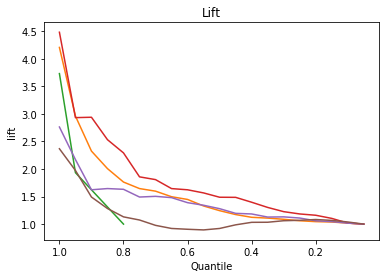

In [160]:
for model in models:
    pyplot.plot(lifts[model]["Quantile"], lifts[model]["Lift"])
    pyplot.gca().invert_xaxis()
    pyplot.xlabel("Quantile")
    pyplot.ylabel("lift")
    pyplot.title("Lift")